# Projekt: Bank Marketing – från EDA till Transfer Learning (DistilBERT) + Unsupervised & Supervised

**Vad gör vi?**  
Vi vill förutsäga om en kund säger **“yes”** till bankens erbjudande (term deposit).  
Datasettet är **Bank Marketing (UCI/OpenML)** och innehåller kund-/kontaktinfo per samtal.

**Varför transfer learning?**  
I stället för att bygga features för hand lånar vi en **förtränad språkmodell (DistilBERT)**.  
Tricket: vi gör om **varje rad till en kort text** (t.ex. `age=41, job=admin, ...`) → DistilBERT gör en **embedding** (vektor) → vi tränar en **enkel klassificerare** ovanpå.  
Detta ger starka representationer snabbt, utan att träna ett stort nät från noll.

**Upplägg (steg för steg):**
1. **EDA & datarening:** beskriv kolumner, klassfördelning, basic grafer.  
   *Obs:* Vi **tar bort `duration`** (läckage – det värdet finns bara efter samtalet).
2. **Unsupervised:** DistilBERT-embeddings → **UMAP (2D)** → **K-Means**.  
   Vi tittar på **Silhouette** (klusterkvalitet utan labels) och **ARI/NMI** (hur kluster råkar aligna med yes/no).
3. **Supervised:** samma embeddings → **Logistisk regression** och **Linear SVM (kalibrerad)**.  
   Vi utvärderar med **Accuracy, ROC-AUC, PR-kurva, Confusion Matrix** och diskuterar precision/recall-trade-offs.
4. **Reflektion:** vad funkar, vad är svårt (obalans, ja/nej), och snabba förbättringsidéer (tröskel-tuning, ev. fin-tuning av BERT, ev. XGBoost).

**Mål:** en tydlig, reproducibel pipeline som visar hur **transfer learning** kan användas även för **tabulär data** via textifiering, plus både **unsupervised** och **supervised** analys.

In [ ]:
import os
import pandas as pd
from sklearn.datasets import fetch_openml

def load_bank_marketing():
    # 1) Try local files (most common names)
    candidates = ["bank-full.csv", "bank.csv", "bankmarketing.csv", "bank-full.txt", "bank.txt"]
    for fn in candidates:
        if os.path.exists(fn):
            print(f"✅ Loading local dataset: {fn}")
            # Bank Marketing is commonly semicolon-separated
            return pd.read_csv(fn, sep=";")

    # 2) Try OpenML
    try:
        print("🌐 Loading dataset from OpenML...")
        oml = fetch_openml("bank-marketing", version=1, as_frame=True, parser="liac-arff", cache=False)
        return oml.frame.copy()
    except Exception as e:
        print("⚠️ Could not load dataset locally or from OpenML.")
        print("Error:", e)
        print("\nTo run this notebook:")
        print("1) Download 'Bank Marketing' dataset (UCI) and place 'bank-full.csv' next to this notebook, then rerun.")
        print("2) Or try again later (OpenML can fail occasionally).")
        return None

bank_df = load_bank_marketing()
if bank_df is not None:
    print("✅ Loaded:", bank_df.shape)
    display(bank_df.head())

In [ ]:
# === Setup & imports (Bank Marketing-projekt) ===
# Installerar paket om de saknas (OK att köra även om de finns)
%pip install -q transformers datasets torch umap-learn scikit-learn pandas matplotlib

import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score

import torch
from transformers import AutoTokenizer, AutoModel

warnings.filterwarnings("ignore")
np.random.seed(42)

# Om du har GPU så används den, annars CPU (helt OK)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Klar ✅  |  PyTorch device:", DEVICE)


Note: you may need to restart the kernel to use updated packages.


c:\Users\abdor\anaconda3\envs\mlcourse\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Klar ✅  |  PyTorch device: cpu



Kolumner: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'Class']
Upptäckt target-kolumn: Class
ℹ️ Ingen 'duration'-kolumn i denna variant (helt okej).
⚠️ Mappar numerisk target via min/max: {'1': 0, '2': 1}

Form: (45211, 17)
Antal features: 16
Numeriska: ['V1', 'V6', 'V10', 'V12', 'V13', 'V14', 'V15'] 
Kategoriska: ['V2', 'V3', 'V4', 'V5', 'V7', 'V8', 'V9', 'V11', 'V16'] 

Målfördelning (0=no, 1=yes):
y
0    39922
1     5289
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
V1,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
V6,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
V10,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
V12,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
V13,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
V14,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
V15,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0



Toppvärden i 'V2':
V2
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
Name: count, dtype: int64

Toppvärden i 'V3':
V3
married     27214
single      12790
divorced     5207
Name: count, dtype: int64

Toppvärden i 'V4':
V4
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

Toppvärden i 'V5':
V5
no     44396
yes      815
Name: count, dtype: int64

Toppvärden i 'V7':
V7
yes    25130
no     20081
Name: count, dtype: int64


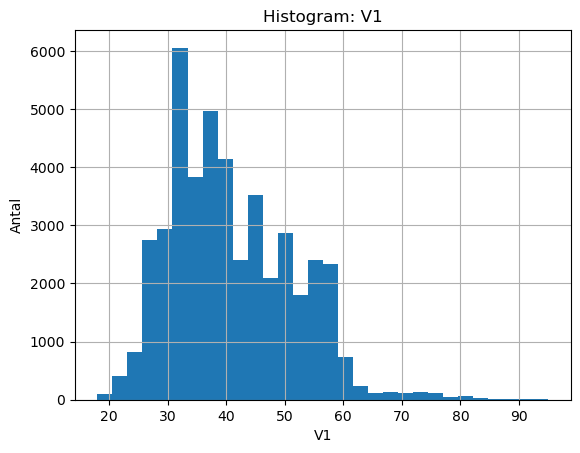

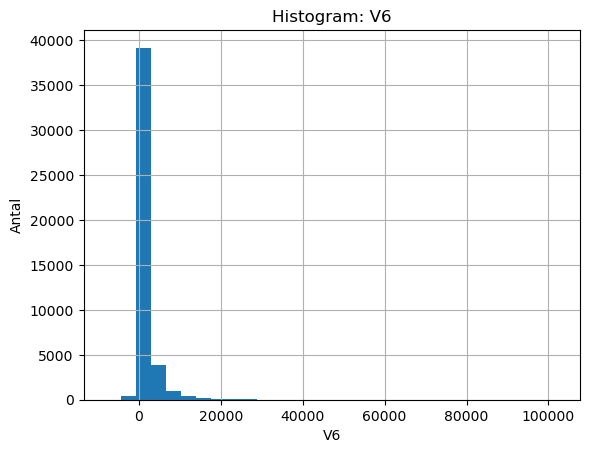

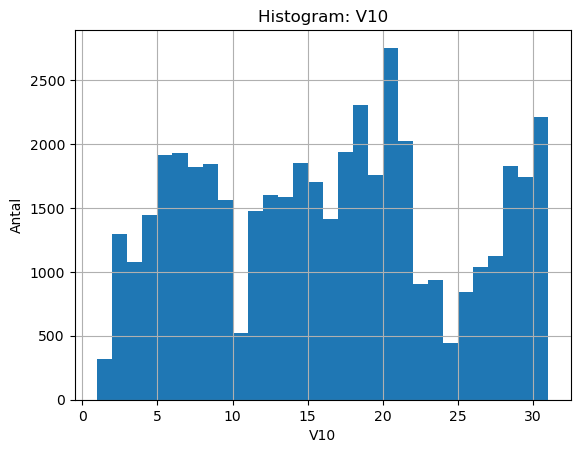

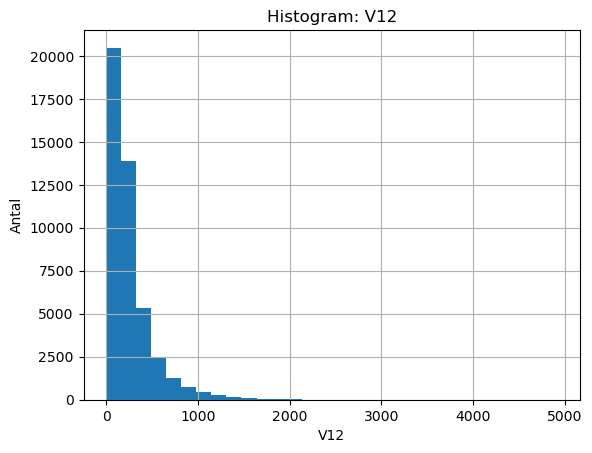

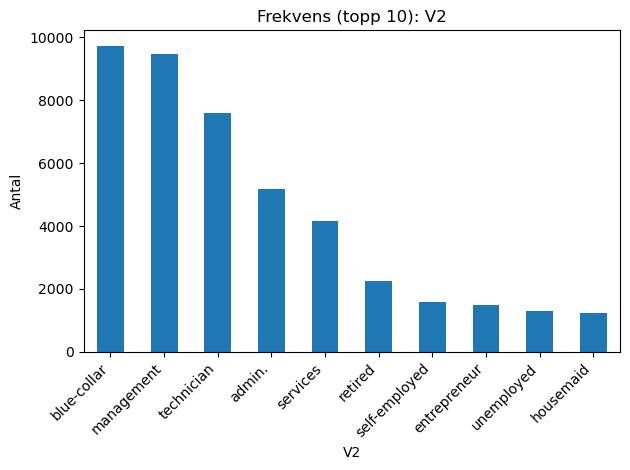

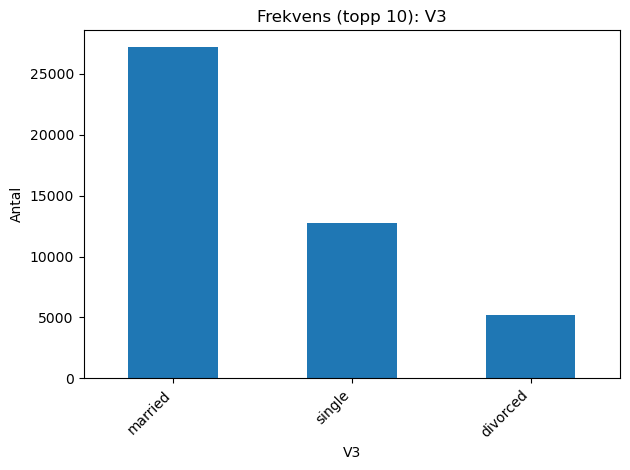

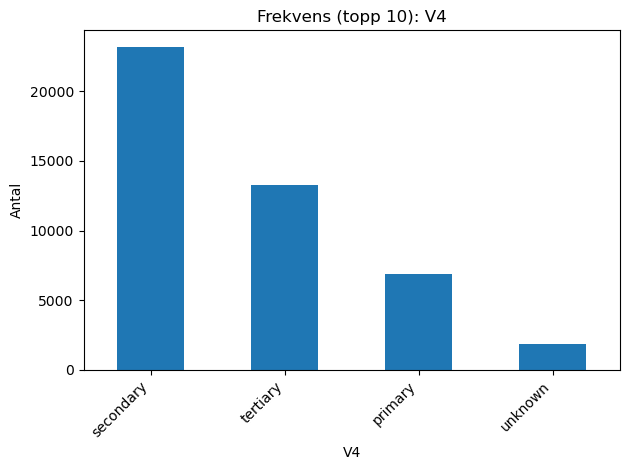

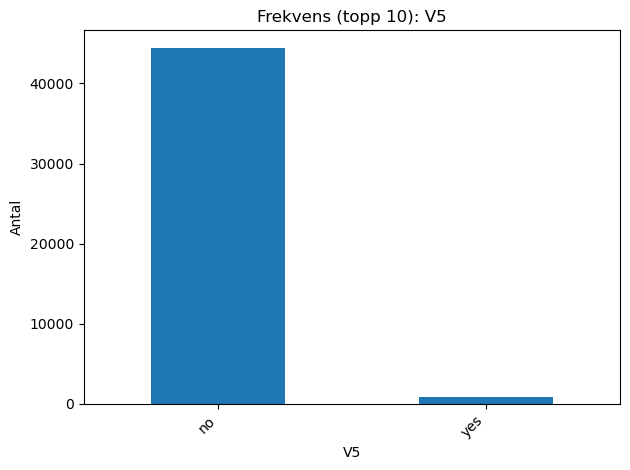


📦 Klar med EDA-bas. Data finns i 'bank_df'. Rader/kolumner: (45211, 17)


In [ ]:
import pandas as pd
from sklearn.datasets import fetch_openml

try:
    oml = fetch_openml(
        "bank-marketing",
        version=1,
        as_frame=True,
        parser="liac-arff",
        cache=False,           # IMPORTANT: avoids corrupted cache
    )
    bank_df = oml.frame.copy()
    print("✅ Loaded from OpenML:", bank_df.shape)

except Exception as e:
    print("⚠️ OpenML failed, falling back to local CSV.")
    print("Error:", e)
    # Put bank-full.csv in the same folder as the notebook
    bank_df = pd.read_csv("bank-full.csv", sep=";")
    print("✅ Loaded from local CSV:", bank_df.shape)

bank_df.head()

Train texter: 36168  | Test texter: 9043
Embeddar TRAIN (unsup urval)...
Embeddar TEST (för senare tolkning)...
Embeddings shape: (8000, 768) (9043, 768)
Silhouette (train, K=2): 0.091
ARI (train): -0.008   |   NMI (train): 0.015


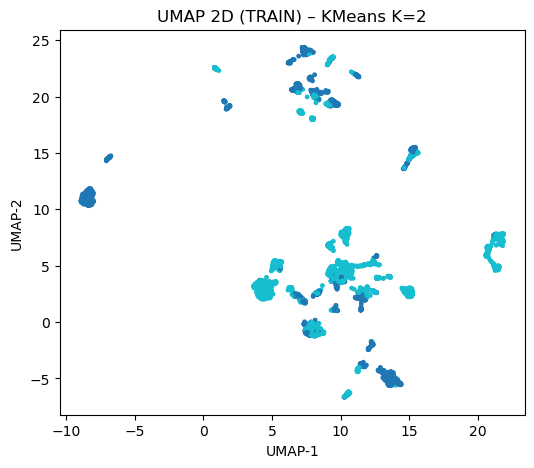

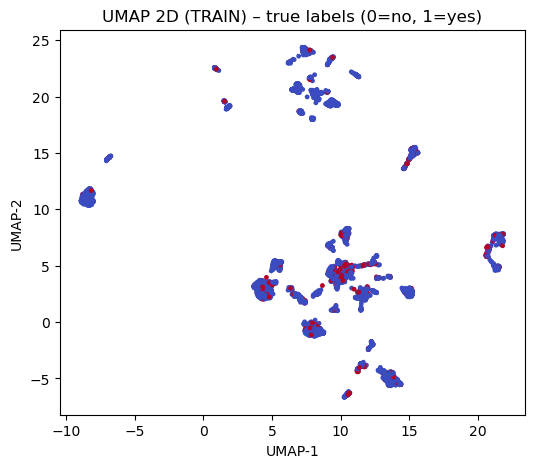


Crosstab (TRAIN): cluster vs y


y,0,1
cluster,,
0,3264,262
1,3782,692



📦 Klar med unsupervised. Vi har embeddings, UMAP och KMeans redo.


In [ ]:
# === Unsupervised på Bank Marketing ===
# Idé: gör varje rad till en kort text → DistilBERT-embedding (fryst) → UMAP (2D) → K-Means.
# Vi använder INTE y när vi tränar UMAP/KMeans (unsupervised). y används bara efteråt för att tolka.

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from transformers import AutoTokenizer, AutoModel
import torch

# 0) Plocka data och features
assert 'bank_df' in globals(), "bank_df saknas – kör Cell 2 först."
df = bank_df.copy()
y = df['y'].values
X = df.drop(columns=['y'])

# 1) Gör om EN rad till en kort text: "col1=val1, col2=val2, ..."
def row_to_text(row):
    parts = []
    for c, v in row.items():
        s = str(v)
        s = re.sub(r"\s+", "_", s.strip().lower())  # enklare värden utan mellanslag
        parts.append(f"{c}={s}")
    return ", ".join(parts)

# 2) Bygg texter för alla rader (det här är vår “språkversion” av tabellen)
texts = X.apply(row_to_text, axis=1).tolist()

# 3) Train/Test split (vi tränar UMAP/KMeans på TRAIN-embeddings, sen bara transform/predict på TEST)
X_train_txt, X_test_txt, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)

print("Train texter:", len(X_train_txt), " | Test texter:", len(X_test_txt))

# 4) Ladda DistilBERT (fryst) för embeddings
MODEL = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
bert = AutoModel.from_pretrained(MODEL)
bert.eval().to(DEVICE)

MAX_TOKENS = 128
BATCH = 64

@torch.no_grad()
def embed_texts(text_list):
    embs = []
    for i in range(0, len(text_list), BATCH):
        batch = text_list[i:i+BATCH]
        toks = tokenizer(
            batch, padding=True, truncation=True, max_length=MAX_TOKENS,
            return_tensors="pt"
        ).to(DEVICE)
        out = bert(**toks).last_hidden_state           # [B, T, H]
        mask = toks['attention_mask'].unsqueeze(-1)    # [B, T, 1]
        sent = (out * mask).sum(1) / mask.sum(1).clamp(min=1)  # mean pooling
        embs.append(sent.cpu().numpy())
    return np.vstack(embs)

# (CPU-snälla) – ta ett urval för UMAP/klustring så det går snabbare
MAX_TRAIN_UNSUP = 8000  # justera upp/ner vid behov
if len(X_train_txt) > MAX_TRAIN_UNSUP:
    idx = np.random.RandomState(42).choice(len(X_train_txt), size=MAX_TRAIN_UNSUP, replace=False)
    X_train_txt_unsup = [X_train_txt[i] for i in idx]
    y_train_unsup = y_train[idx]
else:
    X_train_txt_unsup = X_train_txt
    y_train_unsup = y_train

print("Embeddar TRAIN (unsup urval)...")
Xtr_emb = embed_texts(X_train_txt_unsup)
print("Embeddar TEST (för senare tolkning)...")
Xte_emb = embed_texts(X_test_txt)

print("Embeddings shape:", Xtr_emb.shape, Xte_emb.shape)

# 5) Skala embeddings lite (bra för UMAP/KMeans)
scaler = StandardScaler()
Xtr_emb_s = scaler.fit_transform(Xtr_emb)
Xte_emb_s = scaler.transform(Xte_emb)

# 6) UMAP → 2D (fit bara på TRAIN)
import umap
um = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
Xtr_2d = um.fit_transform(Xtr_emb_s)
Xte_2d = um.transform(Xte_emb_s)

# 7) K-Means (unsupervised). Eftersom y är binär kör vi K=2 för demo.
k = 2
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
cl_train = kmeans.fit_predict(Xtr_emb_s)
cl_test  = kmeans.predict(Xte_emb_s)

# 8) Utvärdera klustring (utan y): Silhouette på TRAIN
sil = silhouette_score(Xtr_emb_s, cl_train)
print(f"Silhouette (train, K={k}): {sil:.3f}")

# 9) Tolkning mot facit (ENDAST efteråt, för analys)
#    ARI/NMI på TRAIN-urvalet (matcha rätt y)
#    Obs: y_train_unsup motsvarar Xtr_emb (urvalet)
ari = adjusted_rand_score(y_train_unsup, cl_train)
nmi = normalized_mutual_info_score(y_train_unsup, cl_train)
print(f"ARI (train): {ari:.3f}   |   NMI (train): {nmi:.3f}")

# 10) Plot UMAP 2D färglagd med kluster (TRAIN)
plt.figure(figsize=(6,5))
plt.scatter(Xtr_2d[:,0], Xtr_2d[:,1], c=cl_train, s=6, cmap="tab10")
plt.title(f"UMAP 2D (TRAIN) – KMeans K={k}")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2"); plt.show()

# (Valfritt) Plot UMAP 2D färglagd med TRUE LABELS (för att “se” alignment)
plt.figure(figsize=(6,5))
plt.scatter(Xtr_2d[:,0], Xtr_2d[:,1], c=y_train_unsup, s=6, cmap="coolwarm")
plt.title("UMAP 2D (TRAIN) – true labels (0=no, 1=yes)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2"); plt.show()

# 11) Enkel crosstab train-kluster vs y (tolkning)
ct = pd.crosstab(pd.Series(cl_train, name="cluster"), pd.Series(y_train_unsup, name="y"))
print("\nCrosstab (TRAIN): cluster vs y")
display(ct)

# 12) Spara det vi behöver till supervised-delen
unsup_artifacts = {
    "scaler": scaler,
    "umap": um,
    "kmeans": kmeans
}
print("\n📦 Klar med unsupervised. Vi har embeddings, UMAP och KMeans redo.")


### Reflektion – Unsupervised (UMAP + KMeans)

Jag testade att klustra utan att använda etiketter (yes/no). Resultaten blev:
- **Silhouette ≈ 0.09** → väldigt svag/semi-separering (0 betyder nästan ingen klusterstruktur).
- **ARI ≈ -0.008** och **NMI ≈ 0.015** → klustren matchar nästan **inte alls** med yes/no (typ som slump).

UMAP-plottarna bekräftar det: man ser små grupper, men de överlappar mycket, och de röda/blå punkterna (riktiga labels) ligger blandade. Slutsats: **representationen fångar struktur**, men den strukturen sammanfaller **inte** tydligt med just målet `y`. Det är inte konstigt här – “ja/nej” styrs ofta av flera subtila faktorer (tidpunkt, tidigare kontakt, personprofil osv.) och är svårare att “gissa” utan facit.

Vad gör jag med detta?
- Jag behåller insikten (det finns segment, men de är inte = yes/no).
- Jag går vidare med **supervised** där vi faktiskt använder etiketterna.


In [7]:
# === Återskapa train/test-texter + BERT-objekt ===
import re, numpy as np
from sklearn.model_selection import train_test_split

assert 'bank_df' in globals(), "bank_df saknas – kör Cell 2 först."
df = bank_df.copy()
y_all = df['y'].values
X = df.drop(columns=['y'])

def row_to_text(row):
    parts = []
    for c, v in row.items():
        s = str(v)
        s = re.sub(r"\s+", "_", s.strip().lower())
        parts.append(f"{c}={s}")
    return ", ".join(parts)

texts_all = X.apply(row_to_text, axis=1).tolist()

texts_train, texts_test, y_train, y_test = train_test_split(
    texts_all, y_all, test_size=0.20, random_state=42, stratify=y_all
)

print("Train texter:", len(texts_train), " | Test texter:", len(texts_test))

# Ladda DistilBERT-verktyg om de saknas
if "DEVICE" not in globals():
    import torch
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from transformers import AutoTokenizer, AutoModel
if "tokenizer" not in globals():
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
if "bert" not in globals():
    bert = AutoModel.from_pretrained("distilbert-base-uncased")
    bert.eval().to(DEVICE)

print("BERT redo på enhet:", DEVICE)


Train texter: 36168  | Test texter: 9043
BERT redo på enhet: cpu


Embeddar TRAIN (supervised)…
Embeddar TEST (supervised)…
Embeddings shape: (36168, 768) (9043, 768)

Accuracy (test): 0.803
ROC AUC (test):  0.876

Classification report (test):
              precision    recall  f1-score   support

          no       0.96      0.81      0.88      7985
         yes       0.35      0.78      0.48      1058

    accuracy                           0.80      9043
   macro avg       0.66      0.79      0.68      9043
weighted avg       0.89      0.80      0.83      9043



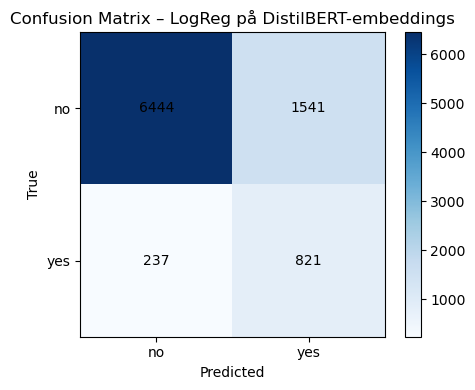

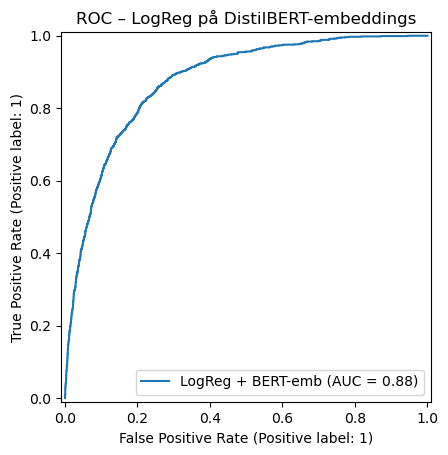

In [ ]:
# === Supervised – DistilBERT-embeddings → Logistisk Regression ===
# Idé: nu använder vi facit (y) och tränar en enkel klassificerare på embeddings.
# Vi återanvänder tokenizer/bert/DEVICE och även texts_train, texts_test, y_train, y_test från tidigare cell.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
import torch

# Säkerställ att saker finns (annars kör om Cell 3)
assert "texts_train" in globals() and "texts_test" in globals(), "Saknar train/test-texter – kör Cell 3 först."
assert "y_train" in globals() and "y_test" in globals(), "Saknar y_train/y_test – kör Cell 3 först."
assert "tokenizer" in globals() and "bert" in globals(), "Saknar tokenizer/bert – kör Cell 3 först."

# Samma embeddings-funktion som i unsupervised (mean pooling över tokens)
@torch.no_grad()
def embed_texts(text_list, max_tokens=128, batch_size=64):
    out_list = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        toks = tokenizer(
            batch, padding=True, truncation=True, max_length=max_tokens,
            return_tensors="pt"
        ).to(DEVICE)
        out = bert(**toks).last_hidden_state           # [B, T, H]
        mask = toks["attention_mask"].unsqueeze(-1)    # [B, T, 1]
        sent = (out * mask).sum(1) / mask.sum(1).clamp(min=1)  # mean
        out_list.append(sent.cpu().numpy())
    return np.vstack(out_list)

print("Embeddar TRAIN (supervised)…")
Xtr = embed_texts(texts_train, max_tokens=128, batch_size=64)
print("Embeddar TEST (supervised)…")
Xte = embed_texts(texts_test,  max_tokens=128, batch_size=64)
print("Embeddings shape:", Xtr.shape, Xte.shape)  # t.ex. (n, 768)

# (Valfritt) lägg till kluster-ID som extra feature om vi körde KMeans i unsupervised
if "unsup_artifacts" in globals():
    from sklearn.preprocessing import StandardScaler
    scaler = unsup_artifacts["scaler"]
    kmeans = unsup_artifacts["kmeans"]
    Xtr_s = scaler.transform(Xtr)
    Xte_s = scaler.transform(Xte)
    cl_tr = kmeans.predict(Xtr_s).reshape(-1, 1)
    cl_te = kmeans.predict(Xte_s).reshape(-1, 1)
    Xtr_aug = np.hstack([Xtr, cl_tr])
    Xte_aug = np.hstack([Xte, cl_te])
else:
    Xtr_aug, Xte_aug = Xtr, Xte

# Träna en enkel Logistisk Regression (balanserad eftersom 'yes' är färre)
clf = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
clf.fit(Xtr_aug, y_train)

# Prediktioner + sannolikheter (behövs för ROC-AUC)
y_pred = clf.predict(Xte_aug)
y_proba = clf.predict_proba(Xte_aug)[:, 1]

# Metriker
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
print(f"\nAccuracy (test): {acc:.3f}")
print(f"ROC AUC (test):  {auc:.3f}\n")

print("Classification report (test):")
print(classification_report(y_test, y_pred, target_names=["no","yes"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix – LogReg på DistilBERT-embeddings")
plt.colorbar()
plt.xticks([0,1], ["no","yes"]); plt.yticks([0,1], ["no","yes"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

# ROC-kurva
RocCurveDisplay.from_predictions(y_test, y_proba, name="LogReg + BERT-emb")
plt.title("ROC – LogReg på DistilBERT-embeddings")
plt.show()


### Reflektion – Supervised (LogReg på DistilBERT-embeddings)

**Resultat (test):**  
- Accuracy ≈ **0.80**  
- ROC AUC ≈ **0.88**  
- För klassen **yes**: precision ≈ **0.35**, recall ≈ **0.78**  
- Confusion matrix visar att vi hittar många av “yes” (821/1058), men vi får också ganska många falska ja (1541 st).

**Tolkning (enkelt):**  
- Modellen är **bra på att inte missa** potentiella ja (hög recall för “yes”), men säger **ja för ofta** (låg precision).  
- Vid kampanjer kan det vara okej om målet är att **inte missa leads** (hellre ringa fler), men dyrt om varje kontakt kostar mycket → då vill man höja precisionen.

**Vad kan förbättras snabbt?**  
- **Justera tröskeln** (inte bara 0.5). Vi kan öka kravet på sannolikhet för “yes” → färre falska ja (högre precision), men lägre recall.  
- **PR-kurva / Precision–Recall AUC** passar bättre vid obalans (färre “yes”).  
- (Valfritt) Lägg till **kluster-ID/UMAP-koordinater** som extra features eller testa en **Linear SVM / XGBoost** ovanpå embeddings.

**Kort slutsats:**  
Transfer-upplägget funkar: DistilBERT-embeddings + enkel logreg ger en användbar modell (AUC ~0.88). Nästa steg är tröskeltuning beroende på vad som är viktigast: **fånga alla ja** (hög recall) eller **ringa färre fel** (hög precision).

Linear SVM – Accuracy: 0.897 | ROC AUC: 0.893

Classification report (SVM):
              precision    recall  f1-score   support

          no       0.91      0.98      0.94      7985
         yes       0.62      0.31      0.41      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.64      0.68      9043
weighted avg       0.88      0.90      0.88      9043



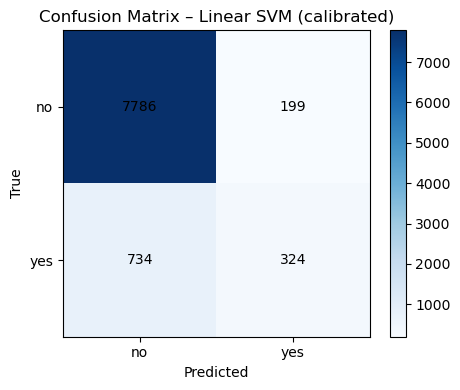

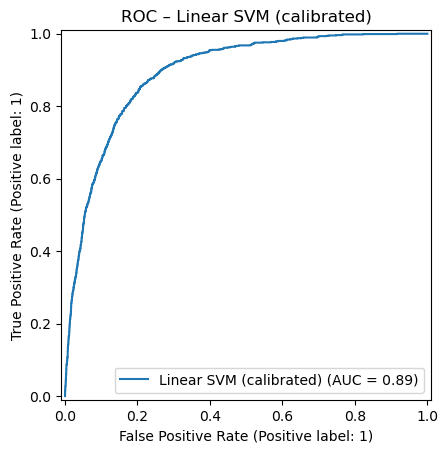

In [9]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay

# Använd samma Xtr_aug/Xte_aug som för LogReg (inkl. ev. kluster-feature)
svm_base = LinearSVC(class_weight="balanced", max_iter=5000)
svm = CalibratedClassifierCV(svm_base, method="sigmoid", cv=3)  # Platt-skalning
svm.fit(Xtr_aug, y_train)

y_pred_svm  = svm.predict(Xte_aug)
y_proba_svm = svm.predict_proba(Xte_aug)[:,1]

acc_svm = accuracy_score(y_test, y_pred_svm)
auc_svm = roc_auc_score(y_test, y_proba_svm)

print(f"Linear SVM – Accuracy: {acc_svm:.3f} | ROC AUC: {auc_svm:.3f}\n")
print("Classification report (SVM):")
print(classification_report(y_test, y_pred_svm, target_names=["no","yes"]))

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix – Linear SVM (calibrated)")
plt.colorbar(); plt.xticks([0,1], ["no","yes"]); plt.yticks([0,1], ["no","yes"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_svm, name="Linear SVM (calibrated)")
plt.title("ROC – Linear SVM (calibrated)"); plt.show()

### Reflektion – Linear SVM (calibrated) på BERT-embeddings

**Resultat (test):** Accuracy **0.897**, ROC AUC **0.893**.  
För **yes** blev **precision ≈ 0.62** och **recall ≈ 0.31**.  
Confusion matrix visar många **falska nej** (missade “yes”): TN=7786, FP=199, FN=734, TP=324.

**Tolkning:**  
- SVM:n är **tuffare** med att säga “yes” (högre precision än LogReg), men **missar fler** faktiska “yes” (lägre recall).  
- Jämfört med LogReg (prec≈0.35, rec≈0.78 för “yes”) ser man tydligt **trade-offen**:  
  - **LogReg**: fångar fler “yes” men ropar “yes” för ofta.  
  - **SVM**: mer försiktig (färre falska ja) men missar många “yes”.

**Vad jag tar med mig:**  
- Vilken modell som “är bäst” beror på **målet**: ska vi **inte missa** leads (prioritera recall) eller **undvika felringningar** (prioritera precision)?  
- Nästa naturliga steg är **tröskeltuning** (PR-kurva) på den kalibrerade SVM:n för att hitta en bättre balans.  
- Vidare förbättringar: testa **class_weight**/kostnader, prova **XGBoost** på embeddings, eller **finetuna DistilBERT** lite (låg LR, få epoker) för mer signal i “yes”.
